# Time Domain Simulation Parameters

In this notebook, we introduce and explore functionality for managing simulation parameters, including simulating multiple samples of time series simulations, and iterating across parameter values.

In [1]:
import numpy as np

from neurodsp.sim import sim_powerlaw, sim_combined, sim_synaptic_current, sim_knee
from neurodsp.plts.combined import plot_timeseries_and_spectra
from neurodsp.utils import set_random_seed

In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB
from apm.plts.utils import figsaver
from apm.sim.funcs import sim_combined_peak
from apm.sim.sim import sim_multiple, sim_across_values, sim_from_sampler
from apm.sim.defs import SIM_PARAMS, SIM_ITERS, SIM_SAMPLERS

In [3]:
# Set plot style
import seaborn as sns
sns.set_context('talk')

## Settings

In [4]:
# Define plot kwargs
plt_kwargs = {
    'ts_range' : [0, 5],
    'f_range' : [1, 100],
    'ts_kwargs' : {'ylabel' : 'Signals'},
    'psd_kwargs' : {
        #'ylabel' : None, 
        'yticks' : [],
        #'yticklabels' : [],
        'minorticks' : False,
    }
}

# Define range for alpha shading across signals
almin = 0.35
almax = 0.85

In [5]:
# Settings for saving figures
SAVE_FIG = True
FIGPATH = APMDB().figs_path / '12_tsparam_sims'

# Create helper function to manage figsaver settings
fsaver = figsaver(SAVE_FIG, FIGPATH)

In [6]:
# Set random seed
set_random_seed(111)

## SimParams Object

The SimParams object stores parameter definitions.

Here, we import a predefined SimParams object that is initialized to store simulation parameter definitions for this project.

In [7]:
# Check the imported SimParams object
SIM_PARAMS

In [8]:
# Check the base parameters
SIM_PARAMS.base

{'n_seconds': 30, 'fs': 250}

In [9]:
# Check the labels of the defined simulation parameters
SIM_PARAMS.labels

['ap', 'syn', 'knee', 'osc', 'burst', 'comb', 'comb_burst', 'peak']

In [10]:
# Check an example set of simulation parameters
SIM_PARAMS['ap']

{'n_seconds': 30, 'fs': 250, 'exponent': -1, 'f_range': (0.5, None)}

In [11]:
# Simulate a time series using parameters from SimParams
sig = sim_powerlaw(**SIM_PARAMS['ap'])

#### Updating Base Parameters

In some cases, we may need to update the base parameters of the simulations.

The SimParams object supports this. Note that once the base parameters have been updated on the object, simulation parameters from the object will reflect the new values.

In [12]:
# Update base parameters
SIM_PARAMS.update_base(n_seconds=60, fs=250)

In [13]:
# Check updated base parameters
SIM_PARAMS.base

{'n_seconds': 60, 'fs': 250}

In [14]:
# Check the simulation parameters for the defined aperiodic signal
SIM_PARAMS['ap']

{'n_seconds': 60, 'fs': 250, 'exponent': -1, 'f_range': (0.5, None)}

## Simulate from Params

Using a simulation parameter definition from a SimParams object we can sample simulated time series. 

This includes simulating multiple samples from the same parameter definition.

In [15]:
# Simulate several instances of a specified simulated definition
ap_sigs = sim_multiple(sim_powerlaw, SIM_PARAMS['ap'], 5)

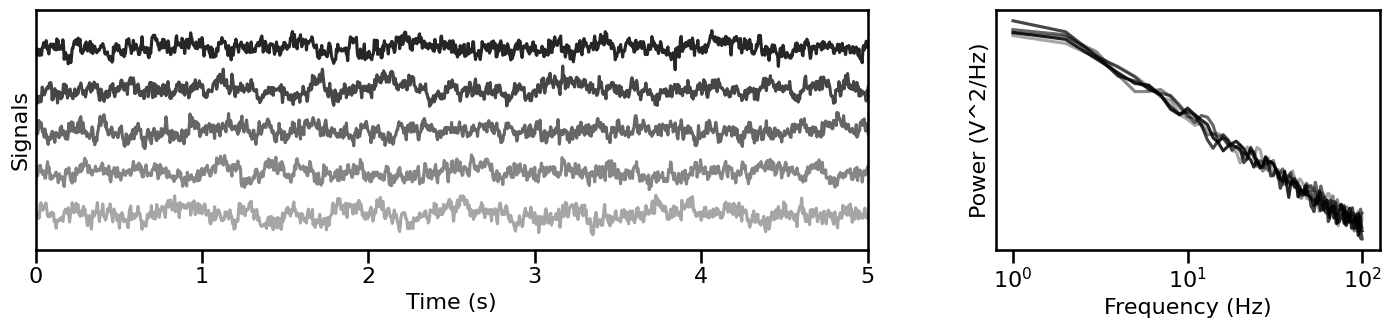

In [16]:
# Visualize simulated aperiodic signals
plot_timeseries_and_spectra(ap_sigs, SIM_PARAMS.fs, **plt_kwargs, **fsaver('params_ap'),
                            alpha=np.linspace(almin, almax, len(ap_sigs)))

## SIM_ITERS

The SimIters object stores definitions to iterate across parameter ranges.

Here, we import a predefined SimIters object that is initialized to store simulation parameter ranges for this project.

In [17]:
# Check the imported SimIters object
SIM_ITERS

In [18]:
# Update base parameters for the sim iterators object
SIM_ITERS.update_base(n_seconds=120)

In [19]:
# Check the labels of the defined simulation iterators
SIM_ITERS.labels

['ap_exp',
 'comb_exp',
 'syn_tscales',
 'kn_knee',
 'osc_freq',
 'osc_pow',
 'peak_freq',
 'peak_pow',
 'peak_bw',
 'comb_burst']

In [20]:
# Check an example iterators defined on object
for params in SIM_ITERS['ap_exp']:
    print(params)

{'n_seconds': 120, 'fs': 250, 'exponent': -3.0, 'f_range': (0.5, None)}
{'n_seconds': 120, 'fs': 250, 'exponent': -2.5, 'f_range': (0.5, None)}
{'n_seconds': 120, 'fs': 250, 'exponent': -2.0, 'f_range': (0.5, None)}
{'n_seconds': 120, 'fs': 250, 'exponent': -1.5, 'f_range': (0.5, None)}
{'n_seconds': 120, 'fs': 250, 'exponent': -1.0, 'f_range': (0.5, None)}
{'n_seconds': 120, 'fs': 250, 'exponent': -0.5, 'f_range': (0.5, None)}
{'n_seconds': 120, 'fs': 250, 'exponent': 0.0, 'f_range': (0.5, None)}


## Simulate From Iterators

Using a parameter iteration definition from a SimIters object we can sample simulated time series across parameter ranges.

In [21]:
# Simulate across different aperiodic exponents, creating 3 time series per parameter value
iter_sims = sim_across_values(sim_powerlaw, SIM_ITERS['ap_exp'], n_sims=3)

In [22]:
# By default, the simulated signals are organized into a dictionary
iter_sims.keys()

dict_keys([-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0])

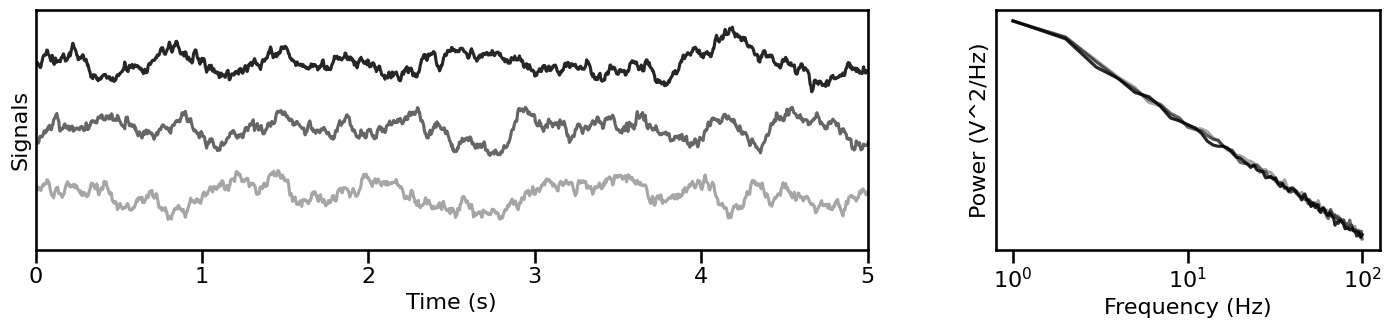

In [23]:
# Plot time series samples for a particular exponent value
plot_timeseries_and_spectra(iter_sims[-2], SIM_ITERS.fs, **plt_kwargs,
                            alpha=np.linspace(almin, almax, len(iter_sims[-2])))

#### Aperiodic Exponent

In [24]:
# Simulate signals across variations of the aperiodic exponent
exp_sims = sim_across_values(sim_powerlaw, SIM_ITERS['ap_exp'], 1, 'array')

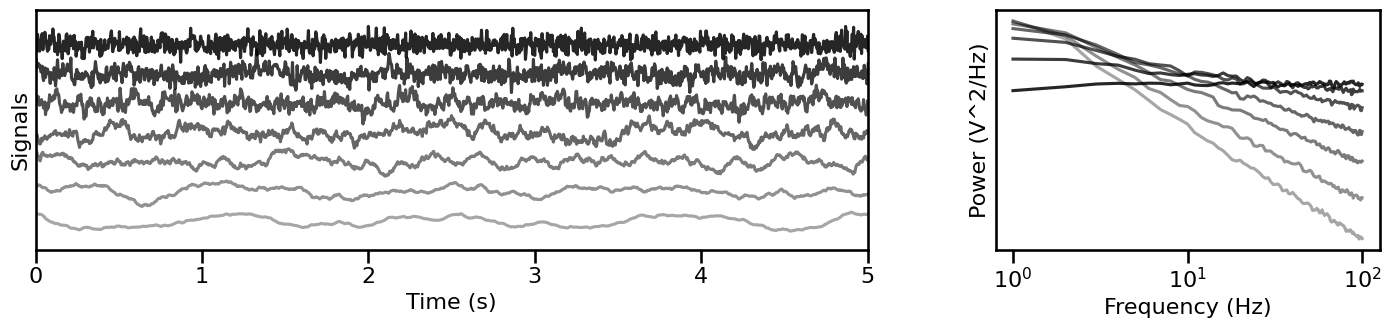

In [25]:
# Plot example simulations across the aperiodic exponent
plot_timeseries_and_spectra(exp_sims, SIM_ITERS.fs, **plt_kwargs, **fsaver('iters_ap'),
                            alpha=np.linspace(almin, almax, len(exp_sims)))

#### Aperiodic Exponent (Combined)

In [26]:
# Simulate signals across variations of the aperiodic exponent, in a combined signal
comb_sims = sim_across_values(sim_combined, SIM_ITERS['comb_exp'], 1, 'array')

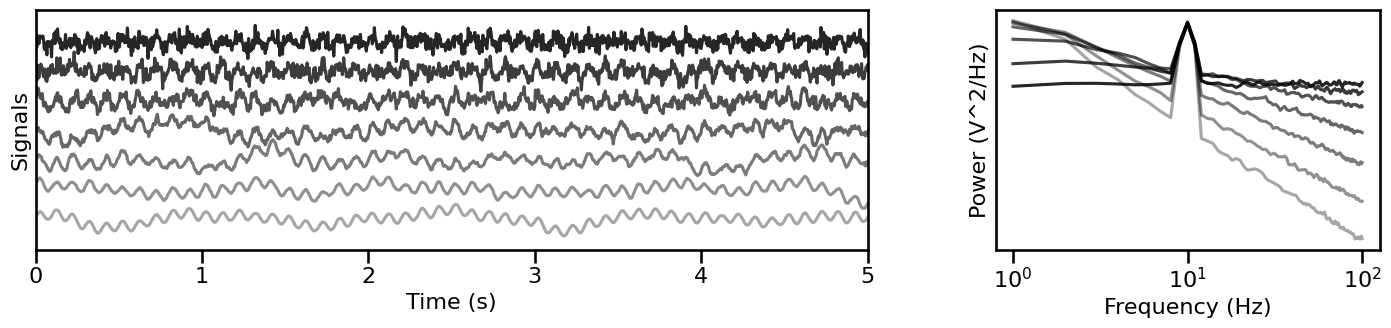

In [27]:
# Plot example simulations across the aperiodic exponent, in a combined signal
plot_timeseries_and_spectra(comb_sims, SIM_ITERS.fs, **plt_kwargs, **fsaver('iters_comb'),
                            alpha=np.linspace(almin, almax, len(comb_sims)))

#### Oscillation Frequency

In [28]:
# Simulate signals across variations of oscillation frequency
freq_sims = sim_across_values(sim_combined, SIM_ITERS['osc_freq'], 1, 'array')

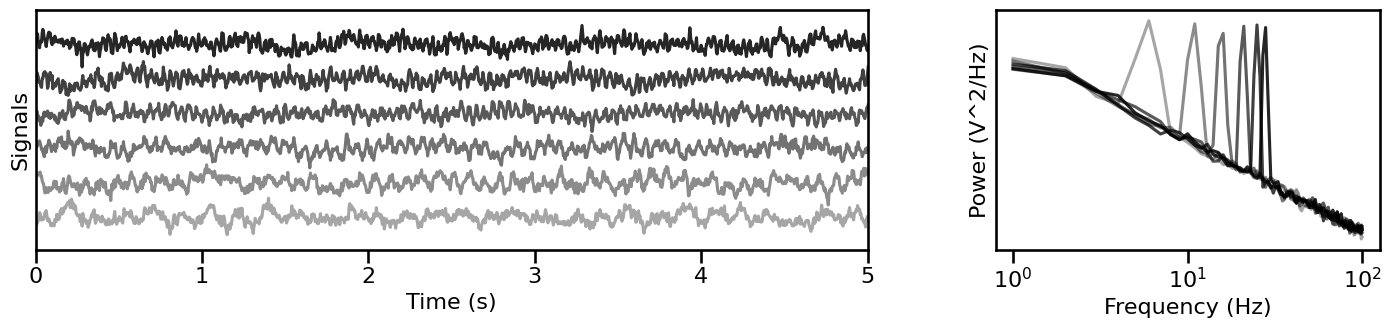

In [29]:
# Plot example simulations across oscillation frequency
plot_timeseries_and_spectra(freq_sims[1::5, :], SIM_ITERS.fs, **plt_kwargs, **fsaver('iters_cf'),
                            alpha=np.linspace(almin, almax, len(freq_sims[1::5, :])))

#### Oscillation Power

In [30]:
# Simulate signals across variations of oscillation power
pow_sims = sim_across_values(sim_combined, SIM_ITERS['osc_pow'], 1, 'array')

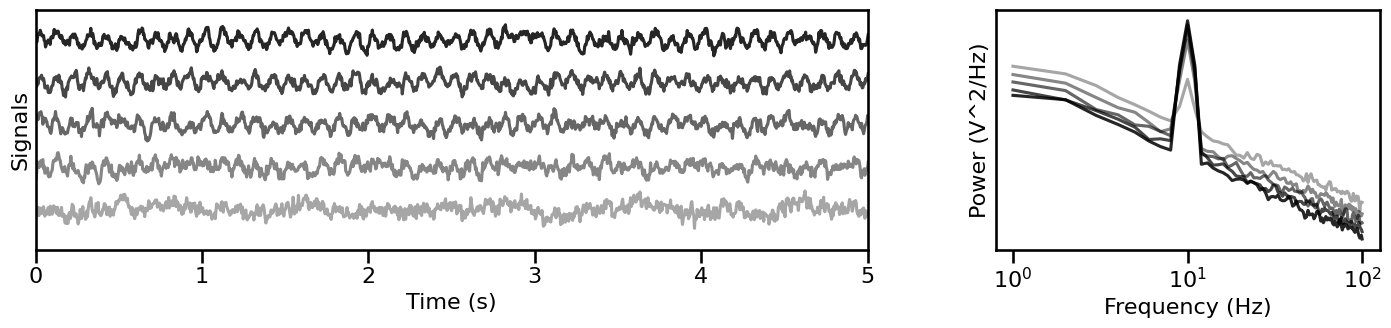

In [31]:
# Plot example simulations across oscillation power
plot_timeseries_and_spectra(pow_sims[1::4, :], SIM_ITERS.fs, **plt_kwargs, **fsaver('iters_pw'),
                            alpha=np.linspace(almin, almax, len(pow_sims[1::4, :])))

#### Synaptic Timescales

In [32]:
# Simulate signals across variations of synaptic timescales
tscale_sims = sim_across_values(sim_synaptic_current, SIM_ITERS['syn_tscales'], 1, 'array')

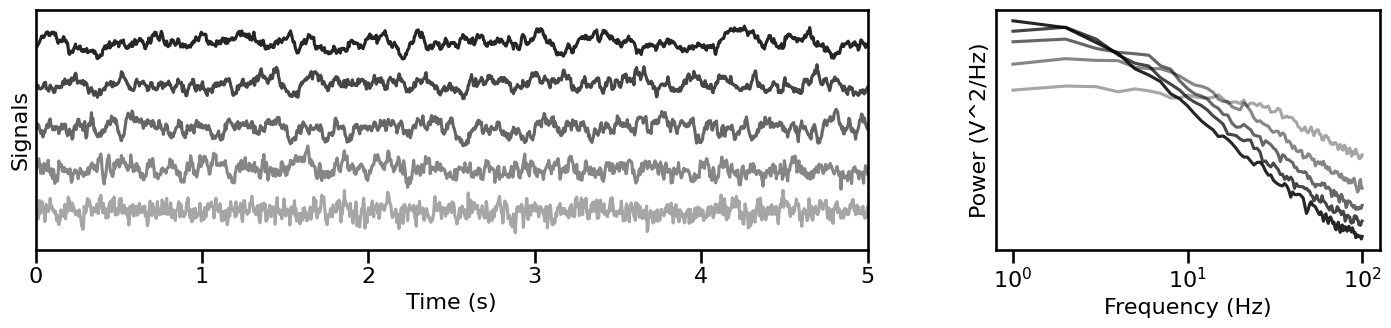

In [33]:
# Plot example simulations across synaptic timescale
plot_timeseries_and_spectra(tscale_sims, SIM_ITERS.fs, **plt_kwargs, **fsaver('iters_tscale'),
                            alpha=np.linspace(almin, almax, len(tscale_sims)))

#### Knee

In [34]:
# Simulate signals across variations of aperiodic knee
knee_sims = sim_across_values(sim_knee, SIM_ITERS['kn_knee'], 1, 'array')

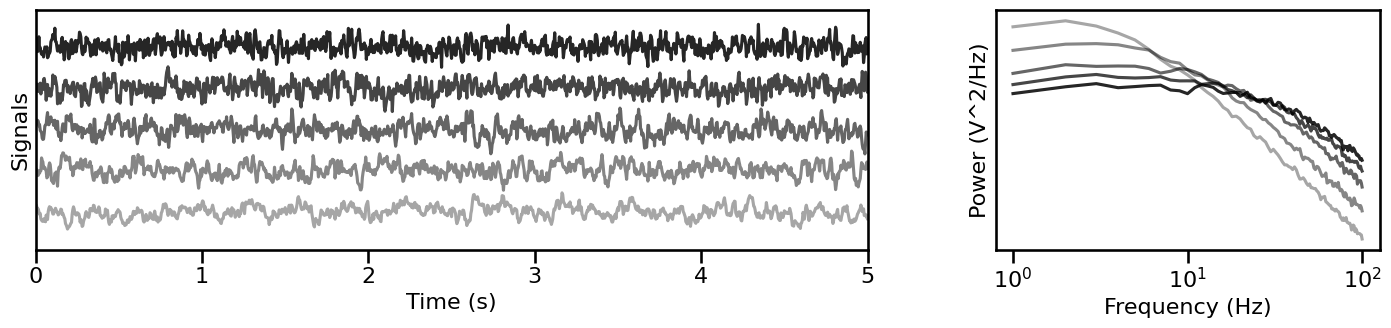

In [35]:
# Plot example simulations across the aperiodic knee
plot_timeseries_and_spectra(knee_sims, SIM_ITERS.fs, **plt_kwargs, **fsaver('iters_knee'),
                            alpha=np.linspace(almin, almax, len(knee_sims)))

#### Peak Bandwidth

In [36]:
# Simulate signals across variations of peak bandwidth
bw_sims = sim_across_values(sim_combined_peak, SIM_ITERS['peak_bw'], 1, 'array')

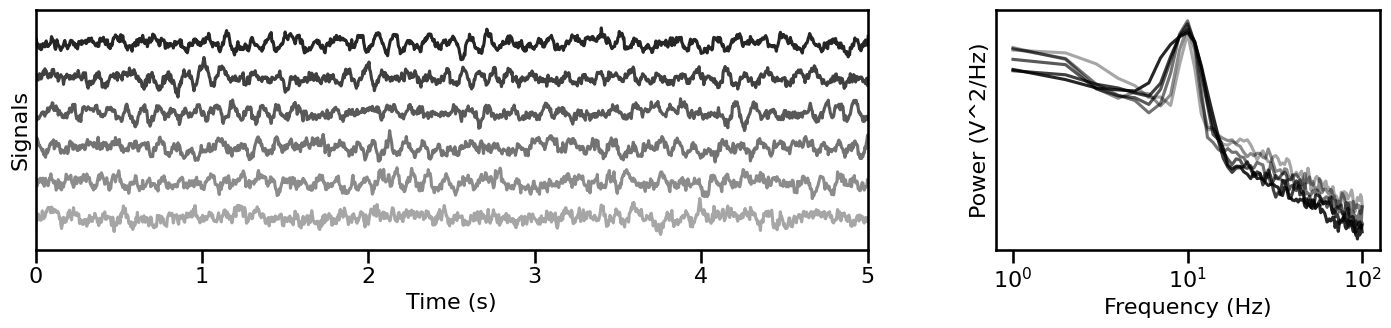

In [37]:
# Plot example simulations across peak bandwidth
plot_timeseries_and_spectra(bw_sims, SIM_ITERS.fs, **plt_kwargs, **fsaver('iters_bw'),
                            alpha=np.linspace(almin, almax, len(bw_sims)))

#### Burst Probability

In [38]:
# Simulate signals across variations of burst probability
burst_sims = sim_across_values(sim_combined, SIM_ITERS['comb_burst'], 1, 'array')

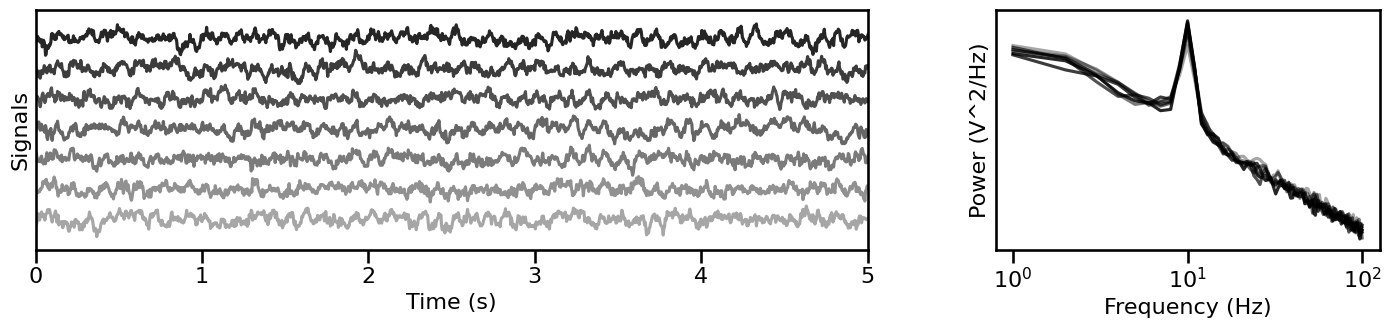

In [39]:
# Plot example simulations across burst probability
plot_timeseries_and_spectra(burst_sims, SIM_ITERS.fs, **plt_kwargs, **fsaver('iters_burst'),
                            alpha=np.linspace(almin, almax, len(burst_sims)))

## Simulate From Samplers

In [40]:
# Check the samplersr object
SIM_SAMPLERS

In [41]:
# Check the labels of the defined simulation samplers
SIM_SAMPLERS.labels

['exp_sampler',
 'tscale_sampler',
 'knee_sampler',
 'comb_sampler',
 'peak_sampler']

#### Combined Signal Sampler

In [42]:
# Simulate a set of time series from sampled parameters
sampled_sigs_comb = sim_from_sampler(sim_combined, SIM_SAMPLERS['comb_sampler'], 5)

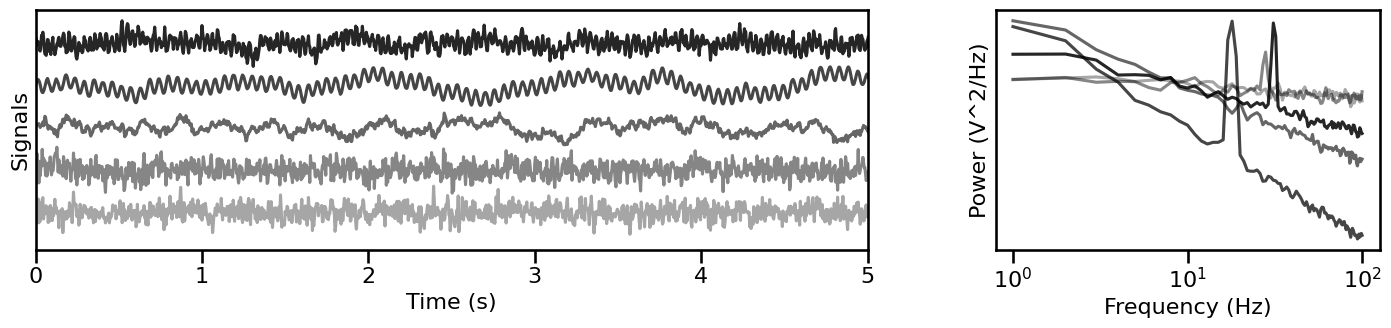

In [43]:
# Plot example simulations from sampled parameters
plot_timeseries_and_spectra(sampled_sigs_comb, SIM_SAMPLERS.fs, **plt_kwargs, **fsaver('samplers_comb'),
                            alpha=np.linspace(almin, almax, len(sampled_sigs_comb)))

#### Peak Signal Sampler

In [44]:
# Simulate a set of time series from sampled parameters
sampled_sigs_peak = sim_from_sampler(sim_combined_peak, SIM_SAMPLERS['peak_sampler'], 5)

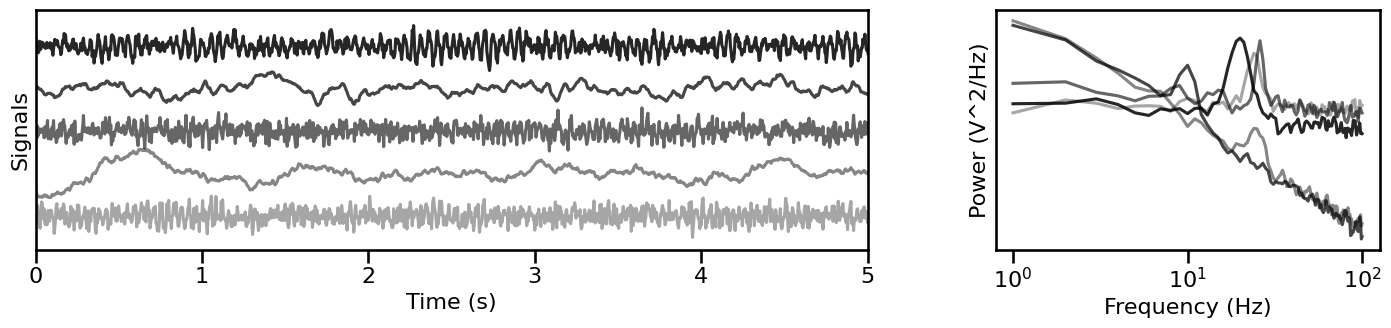

In [45]:
# Plot example simulations from sampled parameters
plot_timeseries_and_spectra(sampled_sigs_peak, SIM_SAMPLERS.fs, **plt_kwargs, **fsaver('samplers_peak'),
                            alpha=np.linspace(almin, almax, len(sampled_sigs_peak)))

## Conclusion

So far, we have explored the time series simulations, and now how to manage simulation parameters across different kinds of iterators and samplers. Next, we will see how these approaches are used to systematically evaluate and compare methods.